In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout


In [10]:
from google.colab import drive
drive.mount('/content/drive')
# Read Energy Consumption Data
energy = pd.read_csv('/content/drive/My Drive/Household energy consumption new/Copy of daily_dataset.csv')

# Preprocess Energy Data
housecount = energy.groupby('day')[['LCLid']].nunique()
energy = energy.groupby('day')[['energy_sum']].sum()
energy = energy.merge(housecount, on=['day'])
energy = energy.reset_index()
energy.day = pd.to_datetime(energy.day, format='%Y-%m-%d').dt.date
energy['avg_energy'] = energy['energy_sum'] / energy['LCLid']
# Get the index of the last row
last_index = energy.index[-1]

# Remove the last row using drop and pop the column values
df = energy.drop(last_index)

# Read Weather Data
weather = pd.read_csv('/content/drive/My Drive/Household energy consumption new/Copy of weather_daily_darksky.csv')
weather['day'] = pd.to_datetime(weather['time']).dt.date
weather = weather[['temperatureMax', 'windBearing', 'dewPoint', 'cloudCover', 'windSpeed',
                   'pressure', 'apparentTemperatureHigh', 'visibility', 'humidity',
                   'apparentTemperatureLow', 'apparentTemperatureMax', 'uvIndex',
                   'temperatureLow', 'temperatureMin', 'temperatureHigh',
                   'apparentTemperatureMin', 'moonPhase', 'day']].dropna()

# Merge Energy and Weather Data
weather_energy = df.merge(weather, on='day')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
df.head()

,day,energy_sum,LCLid,avg_energy
0,2011-11-23,90.385000,13,6.952692
1,2011-11-24,213.412000,25,8.536480
2,2011-11-25,303.993000,32,9.499781
3,2011-11-26,420.976000,41,10.267707
4,2011-11-27,444.883001,41,10.850805


<Axes: xlabel='day'>

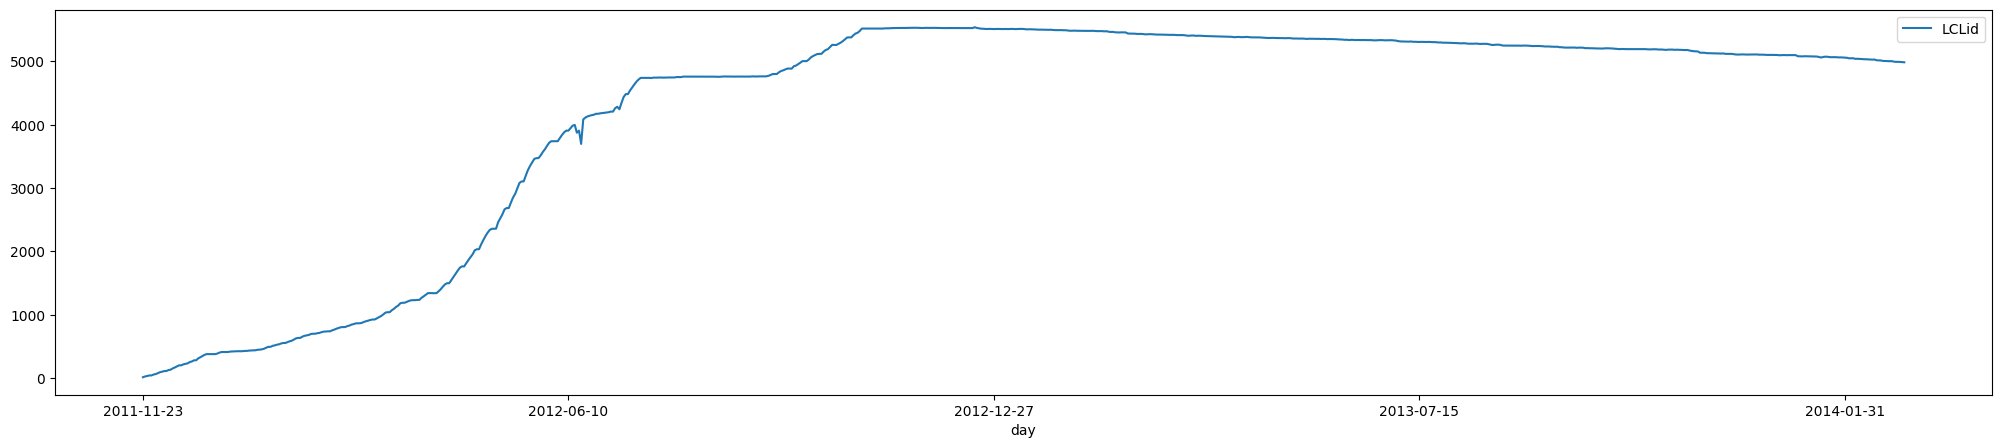

In [4]:
housecount.plot(figsize=(25,5))

In [12]:
df.isnull().sum()

day           0
energy_sum    0
LCLid         0
avg_energy    0
dtype: int64

In [13]:
weather.isnull().sum()

temperatureMax             0
windBearing                0
dewPoint                   0
cloudCover                 0
windSpeed                  0
pressure                   0
apparentTemperatureHigh    0
visibility                 0
humidity                   0
apparentTemperatureLow     0
apparentTemperatureMax     0
uvIndex                    0
temperatureLow             0
temperatureMin             0
temperatureHigh            0
apparentTemperatureMin     0
moonPhase                  0
day                        0
dtype: int64

In [14]:
weather_energy.describe()

,energy_sum,LCLid,avg_energy,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,apparentTemperatureHigh,visibility,humidity,apparentTemperatureLow,apparentTemperatureMax,uvIndex,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase
count,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000
mean,42846.336078,4227.608222,10.368862,13.691028,198.124547,6.548622,0.479407,3.603579,1014.078271,12.712382,11.298996,0.780339,6.144268,12.925393,2.593712,7.770435,7.459117,13.569238,5.775852,0.500822
std,20122.778522,1794.432541,1.853797,6.335321,89.042242,4.921688,0.191572,1.709104,11.105439,7.463318,2.322444,0.094745,6.158643,7.285233,1.867100,4.965253,4.988408,6.414968,6.178088,0.287897
min,90.385000,13.000000,6.952692,-0.060000,0.000000,-7.840000,0.000000,0.200000,979.250000,-6.460000,1.480000,0.430000,-8.880000,-4.110000,0.000000,-5.640000,-5.640000,-0.810000,-8.880000,0.000000
25%,34338.871001,3992.000000,8.566269,9.325000,130.500000,3.110000,0.350000,2.370000,1007.425000,6.635000,10.550000,0.720000,1.445000,7.175000,1.000000,3.980000,3.650000,9.105000,1.075000,0.250000
50%,45814.022999,5138.000000,10.380302,12.580000,221.000000,6.440000,0.470000,3.480000,1014.480000,12.440000,12.040000,0.790000,5.390000,12.580000,2.000000,7.540000,7.090000,12.440000,4.920000,0.500000
75%,58776.530495,5369.000000,11.824568,18.105000,256.000000,10.225000,0.600000,4.600000,1021.660000,18.100000,12.860000,0.850000,11.655000,18.125000,4.000000,11.655000,11.465000,18.085000,11.465000,0.750000
max,82650.492003,5541.000000,15.940238,32.400000,359.000000,17.770000,1.000000,9.960000,1040.920000,32.420000,15.340000,0.980000,20.540000,32.420000,7.000000,20.540000,20.540000,32.400000,20.540000,0.990000


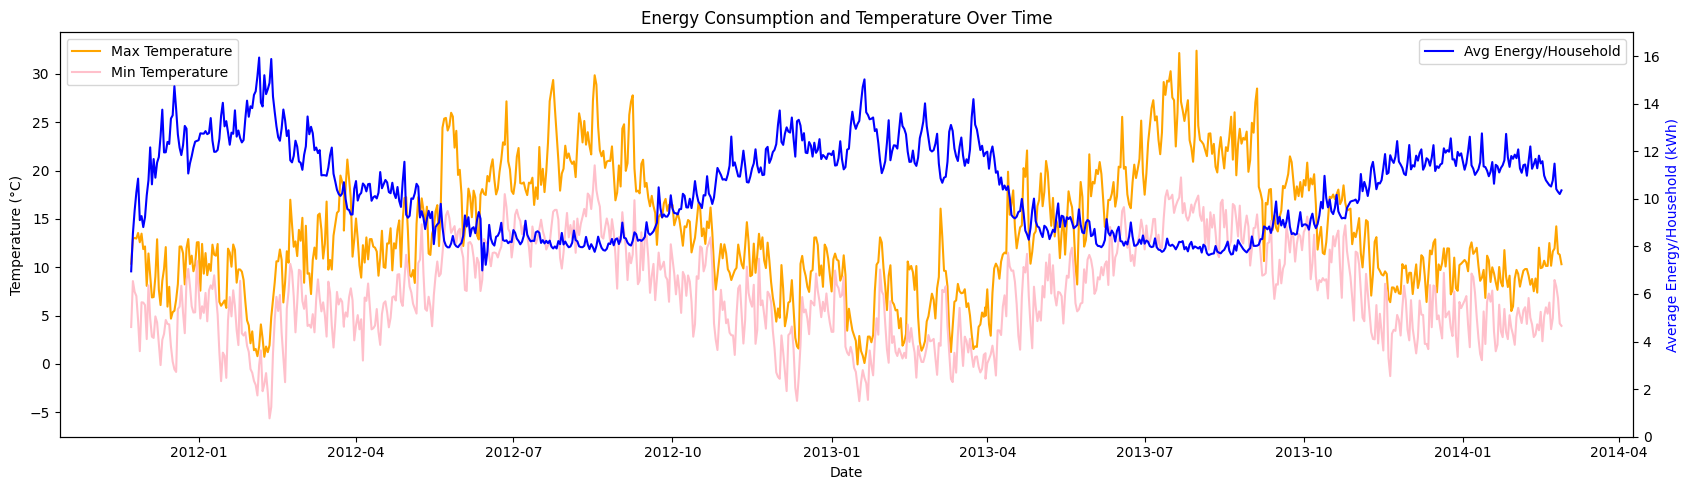

In [15]:
#visualization
fig, ax1 = plt.subplots(figsize=(17, 5))
ax1.plot(weather_energy.day, weather_energy.temperatureMax, color='orange', label='Max Temperature')
ax1.plot(weather_energy.day, weather_energy.temperatureMin, color='pink', label='Min Temperature')
ax1.set_ylabel('Temperature (°C)')
ax1.set_xlabel('Date')
ax1.legend(loc='upper left')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day, weather_energy.avg_energy, color='blue', label='Avg Energy/Household')
ax2.set_ylabel('Average Energy/Household (kWh)', color='blue')
ax2.set_ylim(0, 17)
ax2.legend(loc='upper right')
plt.title('Energy Consumption and Temperature Over Time')
fig.tight_layout()
plt.show()

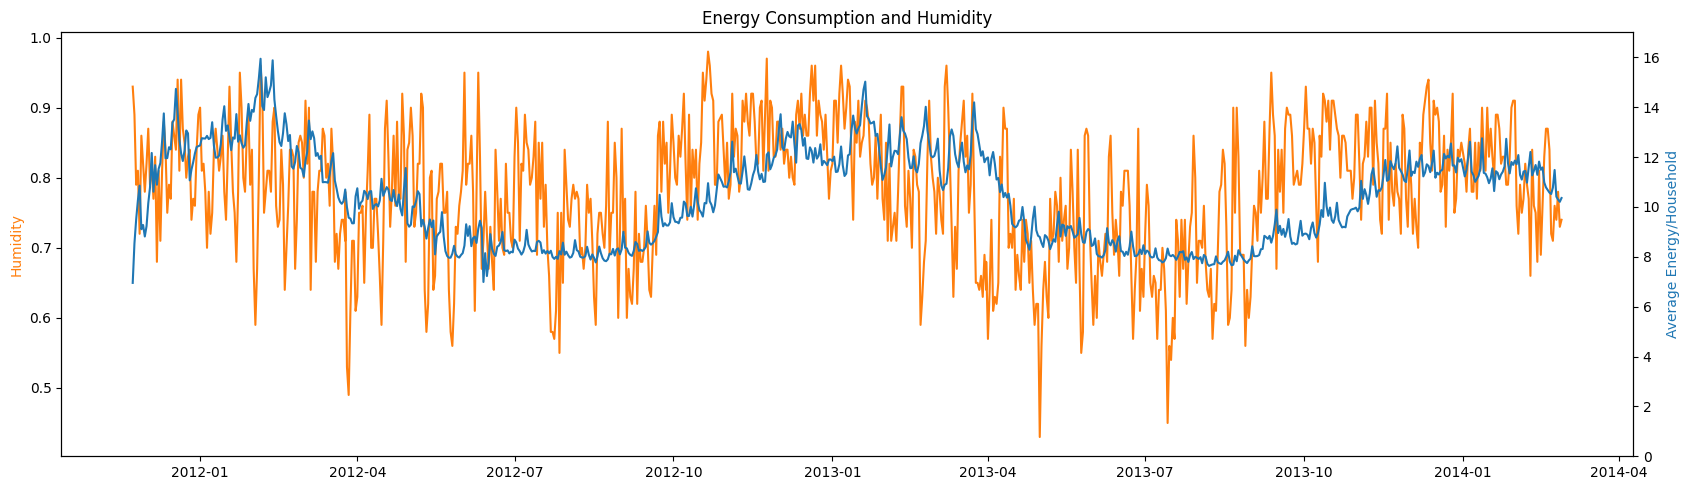

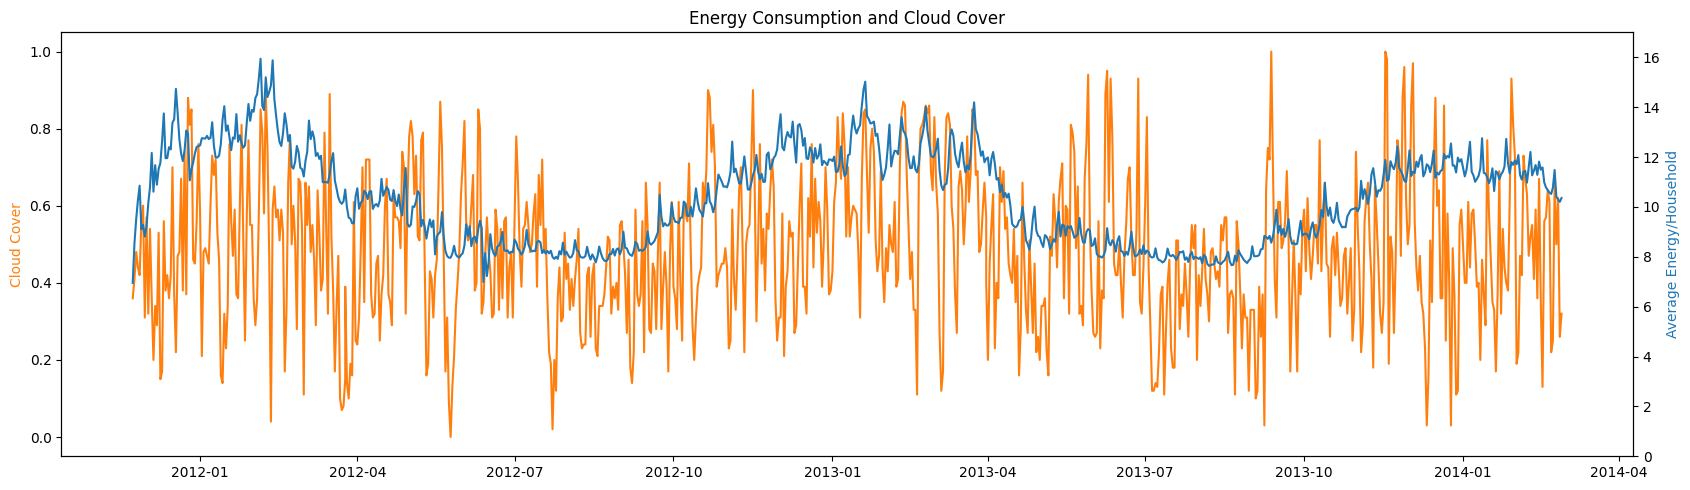

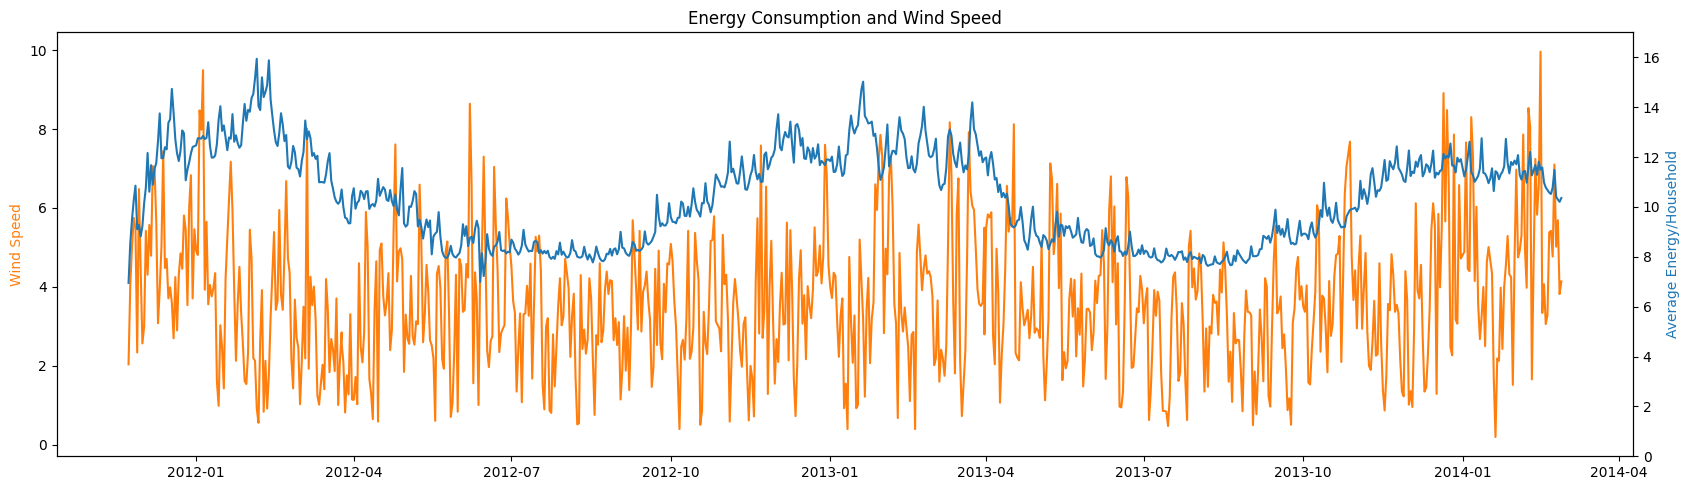

In [16]:
# Visualize Data
def plot_feature_vs_energy(feature, ylabel):
    fig, ax1 = plt.subplots(figsize=(17, 5))
    ax1.plot(weather_energy.day, weather_energy[feature], color='tab:orange')
    ax1.set_ylabel(ylabel, color='tab:orange')
    ax2 = ax1.twinx()
    ax2.plot(weather_energy.day, weather_energy.avg_energy, color='tab:blue')
    ax2.set_ylabel('Average Energy/Household', color='tab:blue')
    ax2.set_ylim(0, 17)
    plt.title(f'Energy Consumption and {ylabel}')
    fig.tight_layout()
    plt.show()

plot_feature_vs_energy('humidity', 'Humidity')
plot_feature_vs_energy('cloudCover', 'Cloud Cover')
plot_feature_vs_energy('windSpeed', 'Wind Speed')




In [18]:
# Read Holiday Data
holiday = pd.read_csv('/content/drive/My Drive/Household energy consumption new/Copy of uk_bank_holidays.csv')
holiday['Bank holidays'] = pd.to_datetime(holiday['Bank holidays'], format='%Y-%m-%d').dt.date


In [19]:
# Merge Holiday Data
weather_energy = weather_energy.merge(holiday, left_on='day', right_on='Bank holidays', how='left')
weather_energy['holiday_ind'] = np.where(weather_energy['Bank holidays'].isna(), 0, 1)
weather_energy.set_index(['day'], inplace=True)

# Remove Unnecessary Columns
weather_model = weather_energy.drop(columns=['energy_sum', 'LCLid', 'Bank holidays', 'Type'])

# Separate Features and Target Variable
X = weather_model.drop(columns=['avg_energy'])
y = weather_model['avg_energy']

In [20]:
weather_model.head()

,avg_energy,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,apparentTemperatureHigh,visibility,humidity,apparentTemperatureLow,apparentTemperatureMax,uvIndex,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase,holiday_ind
day,,,,,,,,,,,,,,,,,,,
2011-11-23,6.952692,10.36,229,6.29,0.36,2.04,1027.12,10.36,8.06,0.93,6.56,10.36,1.0,8.24,3.81,10.36,2.18,0.94,0
2011-11-24,8.536480,12.93,204,8.56,0.41,4.04,1027.22,12.93,10.64,0.89,7.30,12.93,1.0,9.71,8.56,12.93,7.01,0.97,0
2011-11-25,9.499781,13.03,243,7.24,0.48,5.02,1024.47,12.27,12.38,0.79,4.69,13.03,1.0,7.01,7.46,12.27,4.84,0.01,0
2011-11-26,10.267707,12.96,237,6.96,0.44,5.75,1025.80,12.96,13.07,0.81,11.59,12.96,1.0,11.59,7.01,12.96,4.69,0.05,0
2011-11-27,10.850805,13.54,256,5.76,0.42,5.48,1021.11,13.54,13.08,0.72,1.31,13.54,1.0,1.31,4.47,13.54,2.94,0.08,0


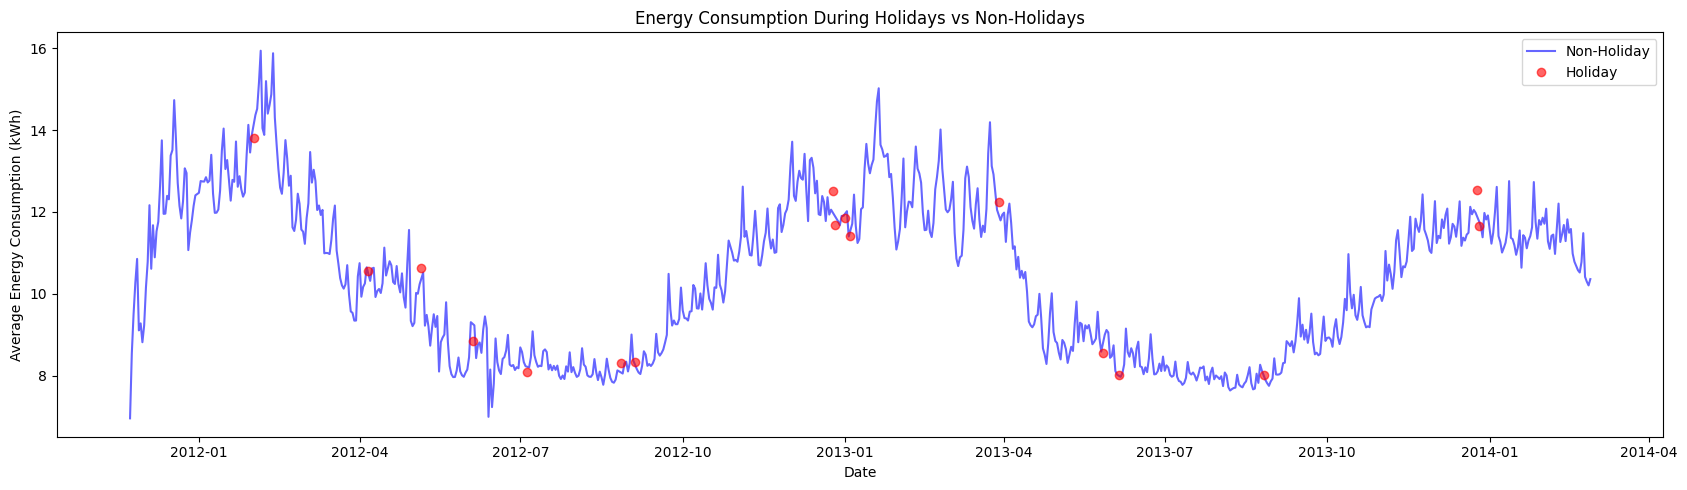

In [21]:
#holiday graph
holidays = weather_model[weather_model['holiday_ind'] == 1]
non_holidays = weather_model[weather_model['holiday_ind'] == 0]


plt.figure(figsize=(17, 5))
plt.plot(non_holidays.index, non_holidays['avg_energy'], label='Non-Holiday', color='blue', alpha=0.6)
plt.plot(holidays.index, holidays['avg_energy'], label='Holiday', color='red', marker='o', linestyle='none', alpha=0.6)
plt.xlabel('Date')
plt.ylabel('Average Energy Consumption (kWh)')
plt.title('Energy Consumption During Holidays vs Non-Holidays')
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
# Scale Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [23]:
X_scaled.shape, y.shape

((827, 18), (827,))

In [24]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Splitting the Data
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Evaluation with different numbers of trees
n_estimators_options = [100, 200, 400, 600, 800]

# Dictionary to store results
results = {}

for n_estimators in n_estimators_options:
    # Creating the Random Forest Regressor
    rf_model = RandomForestRegressor(n_estimators=n_estimators, random_state=42)

    # Fitting the model
    rf_model.fit(X_train_rf, y_train_rf)

    # Making predictions
    y_pred_rf = rf_model.predict(X_test_rf)

    # Calculating metrics
    mse_rf = mean_squared_error(y_test_rf, y_pred_rf)

    r2_rf = r2_score(y_test_rf, y_pred_rf)
    mae_rf = mean_absolute_error(y_test_rf, y_pred_rf)

    rmse_rf = np.sqrt(mse_rf)

    results[n_estimators] = {'MSE': mse_rf, 'R2': r2_rf, 'MAE': mae_rf, 'RMSE': rmse_rf}
    print(f"Random Forest with {n_estimators} trees - MSE: {mse_rf}, R2: {r2_rf}, MAE: {mae_rf}, RMSE: {rmse_rf}")

# Print the results
print("Results:", results)

Random Forest with 100 trees - MSE: 0.5736479314510115, R2: 0.8445860109080651, MAE: 0.5526167108104757, RMSE: 0.7573954920984224
Random Forest with 200 trees - MSE: 0.5577961834210998, R2: 0.8488806021727408, MAE: 0.5460775754186625, RMSE: 0.7468575389062494
Random Forest with 400 trees - MSE: 0.5696948944248301, R2: 0.8456569765990125, MAE: 0.5498743656721787, RMSE: 0.7547813553770589
Random Forest with 600 trees - MSE: 0.5746146632933474, R2: 0.8443241017408524, MAE: 0.5506412632953643, RMSE: 0.7580334183222712
Random Forest with 800 trees - MSE: 0.5713270592658892, R2: 0.8452147868256388, MAE: 0.5487293953398774, RMSE: 0.7558617990518434
Results: {100: {'MSE': 0.5736479314510115, 'R2': 0.8445860109080651, 'MAE': 0.5526167108104757, 'RMSE': 0.7573954920984224}, 200: {'MSE': 0.5577961834210998, 'R2': 0.8488806021727408, 'MAE': 0.5460775754186625, 'RMSE': 0.7468575389062494}, 400: {'MSE': 0.5696948944248301, 'R2': 0.8456569765990125, 'MAE': 0.5498743656721787, 'RMSE': 0.75478135537705

count    827.000000
mean      10.368862
std        1.853797
min        6.952692
25%        8.566269
50%       10.380302
75%       11.824568
max       15.940238
Name: avg_energy, dtype: float64


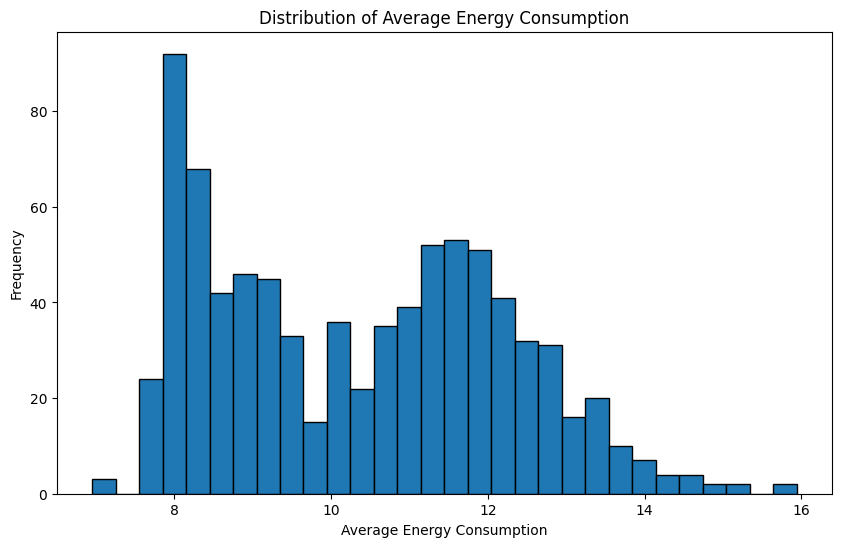

In [25]:
import matplotlib.pyplot as plt

# Descriptive Statistics
print(y.describe())

# Histogram
plt.figure(figsize=(10, 6))
plt.hist(y, bins=30, edgecolor='k')
plt.title('Distribution of Average Energy Consumption')
plt.xlabel('Average Energy Consumption')
plt.ylabel('Frequency')
plt.show()

In [26]:
# Apply PCA
pca = PCA(n_components=8)
X_pca = pca.fit_transform(X_scaled)


In [27]:

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42,shuffle=True)

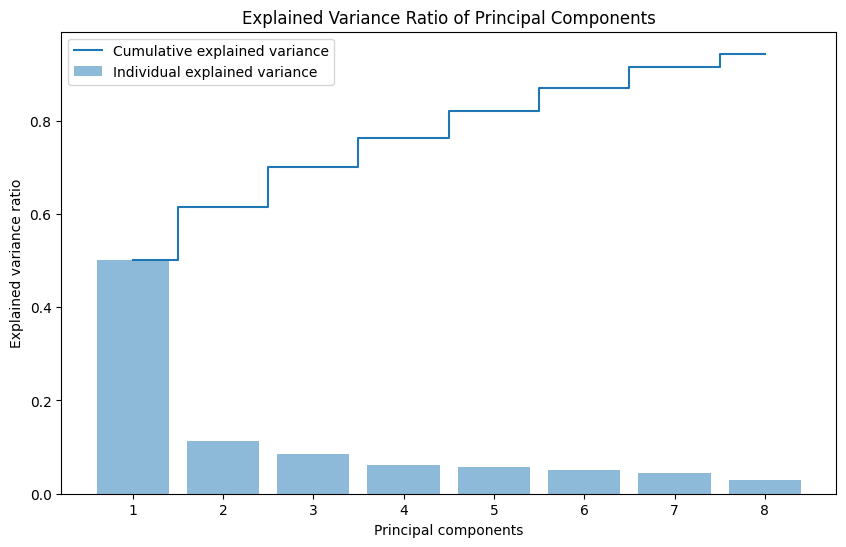

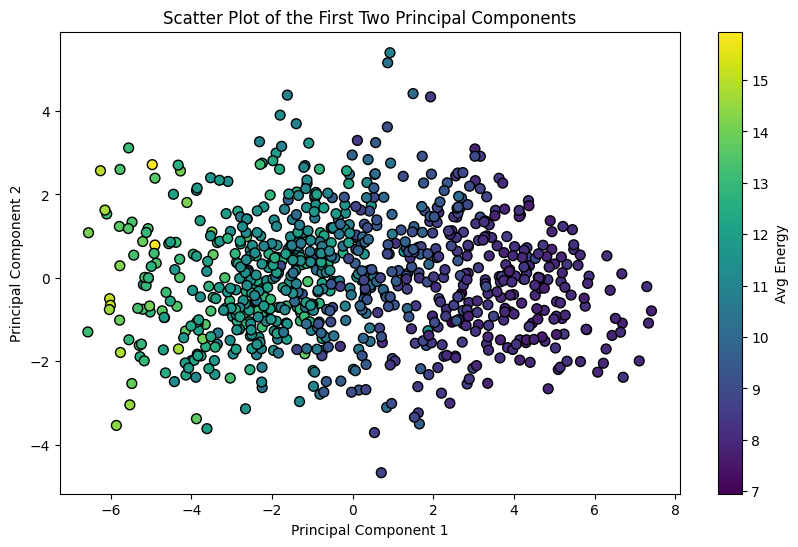

In [28]:
plt.figure(figsize=(10, 6))
plt.bar(range(1, 9), pca.explained_variance_ratio_, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, 9), np.cumsum(pca.explained_variance_ratio_), where='mid', label='Cumulative explained variance')
plt.xlabel('Principal components')
plt.ylabel('Explained variance ratio')
plt.legend(loc='best')
plt.title('Explained Variance Ratio of Principal Components')
plt.show()

# Scatter Plot of the First Two Principal Components
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', edgecolor='k', s=50)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatter Plot of the First Two Principal Components')
plt.colorbar(label='Avg Energy')
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow.keras.backend as K

# Custom R² metric
def r2_keras(y_true, y_pred):
    residual_sum_of_squares = K.sum(K.square(y_true - y_pred))
    total_sum_of_squares = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - residual_sum_of_squares / (total_sum_of_squares + K.epsilon())

# Custom RMSE metric
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# Reshape data for GRU input
X_train_gru = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_gru = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Define and train the GRU model
model = Sequential()

# Adding first GRU layer with dropout
model.add(GRU(units=128, input_shape=(X_train.shape[1], 1), return_sequences=True))
model.add(Dropout(0.1))

# Adding second GRU layer with dropout
model.add(GRU(units=64, return_sequences=True))
model.add(Dropout(0.1))

# Adding third GRU layer without return_sequences
model.add(GRU(units=32))
model.add(Dropout(0.1))

# Adding the output layer
model.add(Dense(units=1))
# Define callbacks with mode='min' for RMSE
early_stopping = EarlyStopping(monitor='val_mean_squared_error', patience=35, restore_best_weights=True, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_mean_squared_error', factor=0.2, patience=20, min_lr=0.001, mode='min')

# Compile the model with RMSE added to the metrics
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error', 'mean_absolute_error', r2_keras, rmse])

# Train the model with early stopping and learning rate reduction on plateau
history = model.fit(X_train_gru, y_train, epochs=500, batch_size=16, validation_data=(X_test_gru, y_test), callbacks=[early_stopping, reduce_lr])


Epoch 1/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 76.6617 - mean_absolute_error: 8.1049 - mean_squared_error: 76.6617 - r2_keras: -23.4624 - rmse: 8.3067 - val_loss: 4.7306 - val_mean_absolute_error: 1.7713 - val_mean_squared_error: 4.7306 - val_r2_keras: -0.3893 - val_rmse: 2.1227 - learning_rate: 0.0010
Epoch 2/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.0702 - mean_absolute_error: 1.6905 - mean_squared_error: 4.0702 - r2_keras: -0.2658 - rmse: 1.9910 - val_loss: 3.7408 - val_mean_absolute_error: 1.6684 - val_mean_squared_error: 3.7408 - val_r2_keras: -0.0945 - val_rmse: 1.8933 - learning_rate: 0.0010
Epoch 3/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.9042 - mean_absolute_error: 1.6305 - mean_squared_error: 3.9042 - r2_keras: -0.1821 - rmse: 1.9524 - val_loss: 3.6333 - val_mean_absolute_error: 1.6547 - val_mean_squared_error: 3.6333 - val_r2_keras: -0.0668 - val_rmse: 1.8699 - learning_rate: 0.0010
Epoch 4/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss

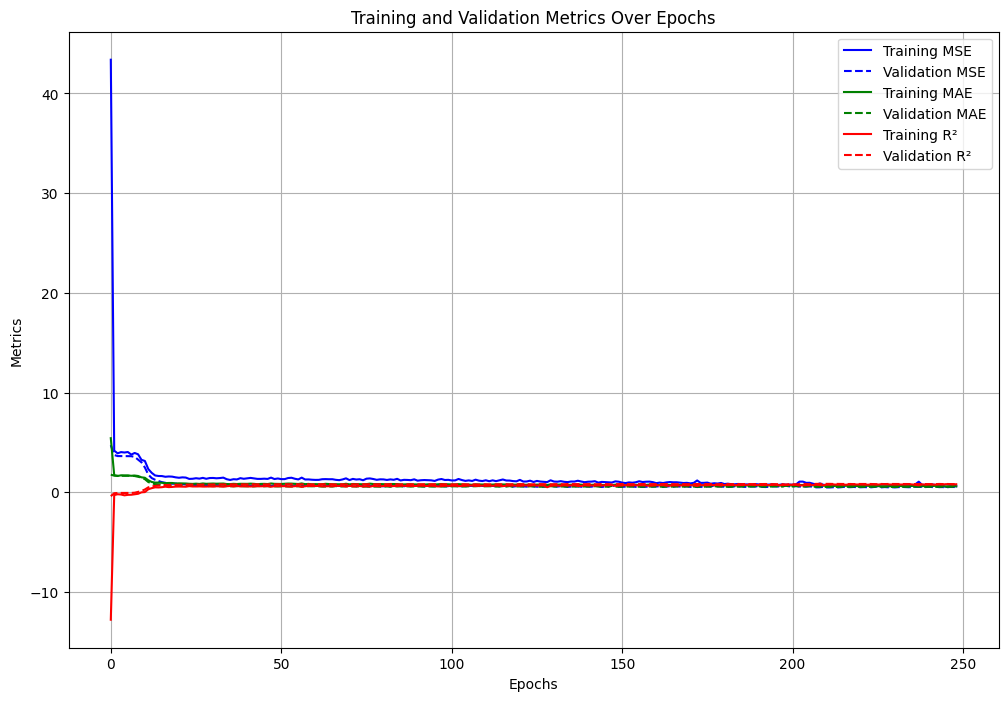

In [ ]:
# Plot training and validation loss, and additional metrics over epochs
plt.figure(figsize=(12, 8))

# Plot Mean Squared Error
plt.plot(history.history['mean_squared_error'], label='Training MSE', color='blue', linestyle='-')
plt.plot(history.history['val_mean_squared_error'], label='Validation MSE', color='blue', linestyle='--')

# Plot Mean Absolute Error
plt.plot(history.history['mean_absolute_error'], label='Training MAE', color='green', linestyle='-')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE', color='green', linestyle='--')


# Plot R-squared (custom metric)
plt.plot(history.history['r2_keras'], label='Training R²', color='red', linestyle='-')
plt.plot(history.history['val_r2_keras'], label='Validation R²', color='red', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Training and Validation Metrics Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3505 - mean_absolute_error: 0.4449 - mean_squared_error: 0.3505 - r2_keras: 0.8972 - rmse: 0.5851
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4629 - mean_absolute_error: 0.5127 - mean_squared_error: 0.4629 - r2_keras: 0.8611 - rmse: 0.6776 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training Loss: [0.3299436867237091, 0.3299436867237091, 0.43123283982276917, 0.9010149836540222, 0.5674034357070923]
Testing Loss: [0.48085299134254456, 0.48085299134254456, 0.5328308939933777, 0.8554230332374573, 0.6880836486816406]
Training MSE: 0.3299437280272316
Testing MSE: 0.4808529278702556
Training MAE: 0.4312328469823256
Testing MAE: 0.5328308493459288
Training RMSE: 0.5744072841000814
Testing RMSE: 0.6934355974928426
Training R-squared: 0.9066943127215443
Testing R-squared: 0.8667007387052802


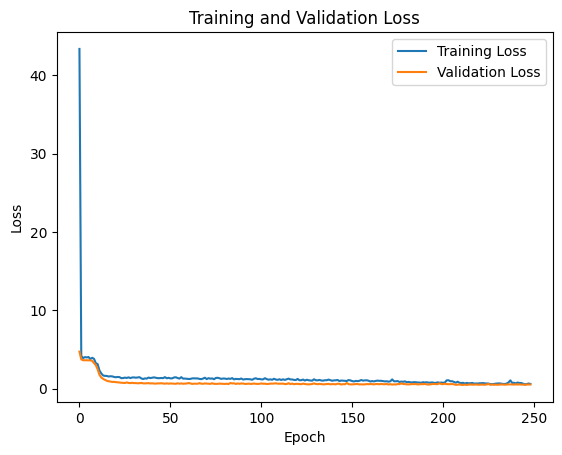

In [ ]:
# Evaluate the model on training and testing data
train_loss = model.evaluate(X_train_gru, y_train)
test_loss = model.evaluate(X_test_gru, y_test)

# Predictions
y_pred_train = model.predict(X_train_gru)
y_pred_test = model.predict(X_test_gru)

# Calculate additional metrics for training and testing
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
# Predictions
y_pred_train = model.predict(X_train_gru)
y_pred_test = model.predict(X_test_gru)

# Calculate additional metrics for training and testing
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
# Calculate Mean Squared Error (MSE) for training and testing
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)


print("Training Loss:", train_loss)
print("Testing Loss:", test_loss)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
print("Training MAE:", mae_train)
print("Testing MAE:", mae_test)
print("Training RMSE:", rmse_train)
print("Testing RMSE:", rmse_test)
print("Training R-squared:", r2_train)
print("Testing R-squared:", r2_test)

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

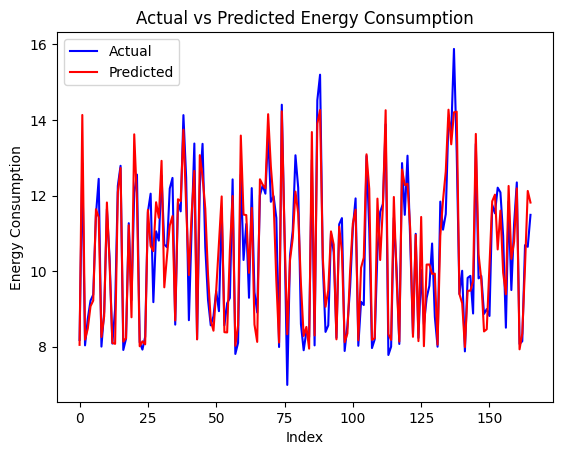

In [ ]:
# Plot actual vs predicted values over time
plt.plot(np.arange(len(y_test)), y_test, color='blue', label='Actual')
plt.plot(np.arange(len(y_pred_test)), y_pred_test, color='red', label='Predicted')
plt.xlabel('Index')
plt.ylabel('Energy Consumption')
plt.title('Actual vs Predicted Energy Consumption')
plt.legend()
plt.show()


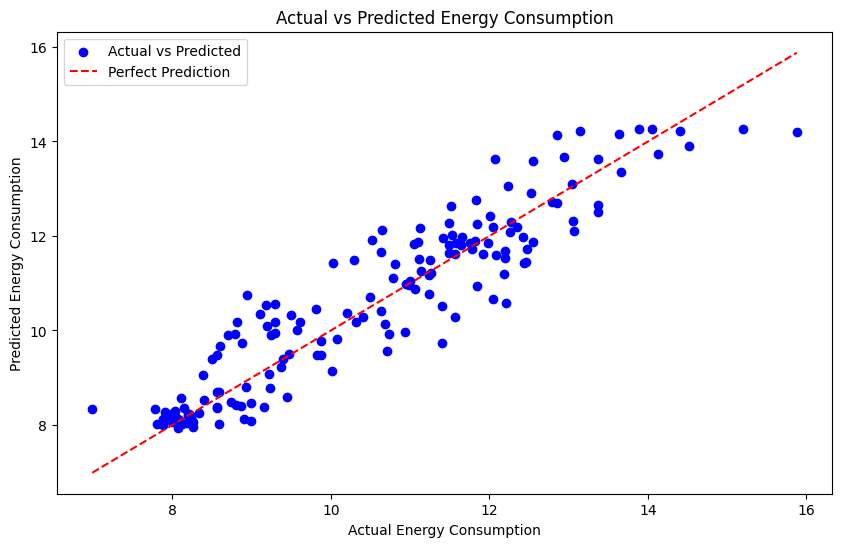

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, color='blue', label='Actual vs Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Energy Consumption')
plt.ylabel('Predicted Energy Consumption')
plt.title('Actual vs Predicted Energy Consumption')
plt.legend()
plt.show()


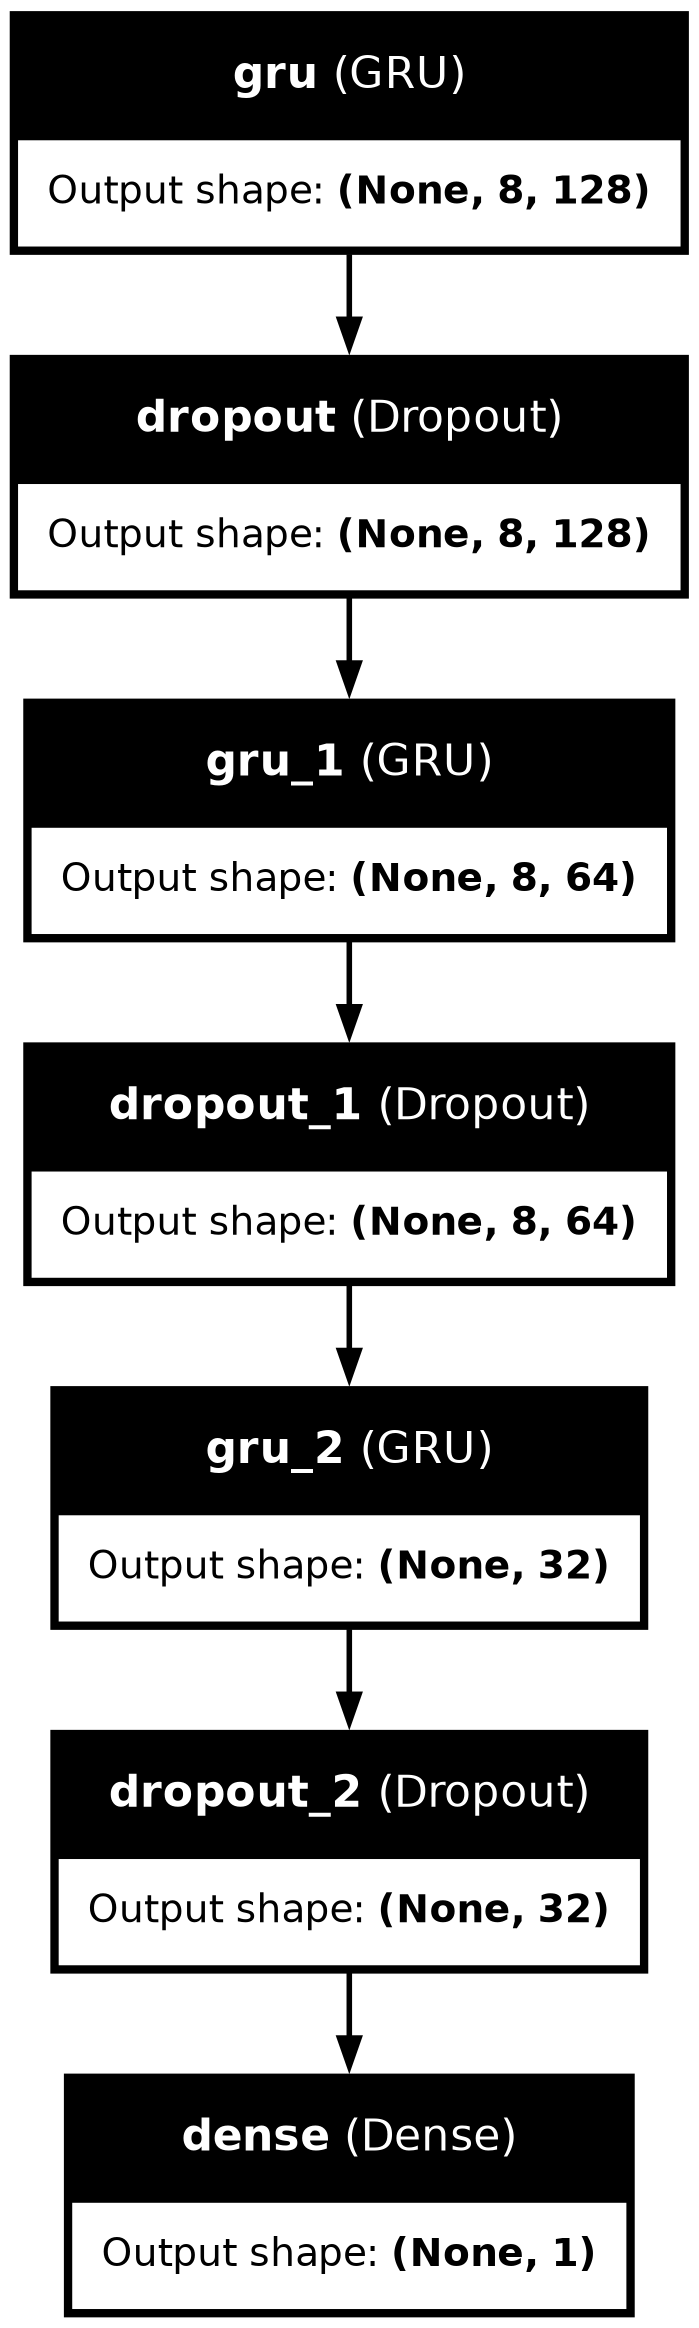

In [ ]:
from keras.utils import plot_model

# Visualize model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


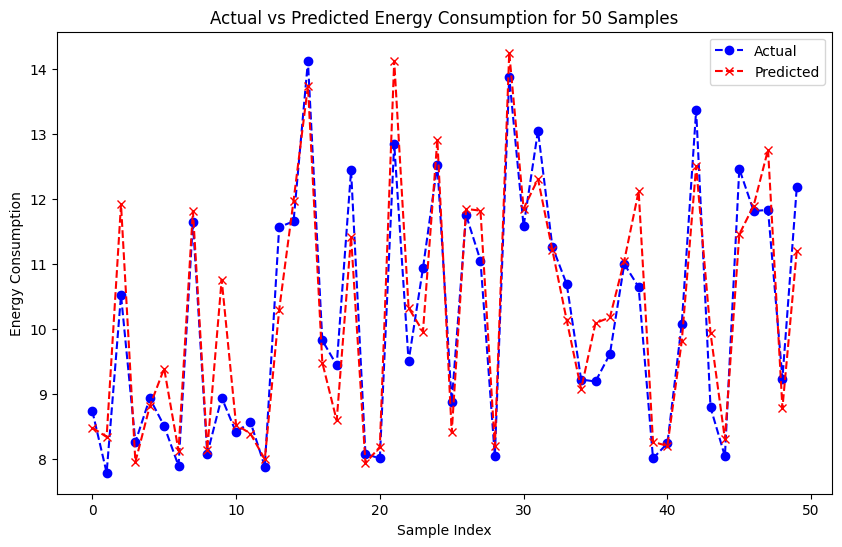

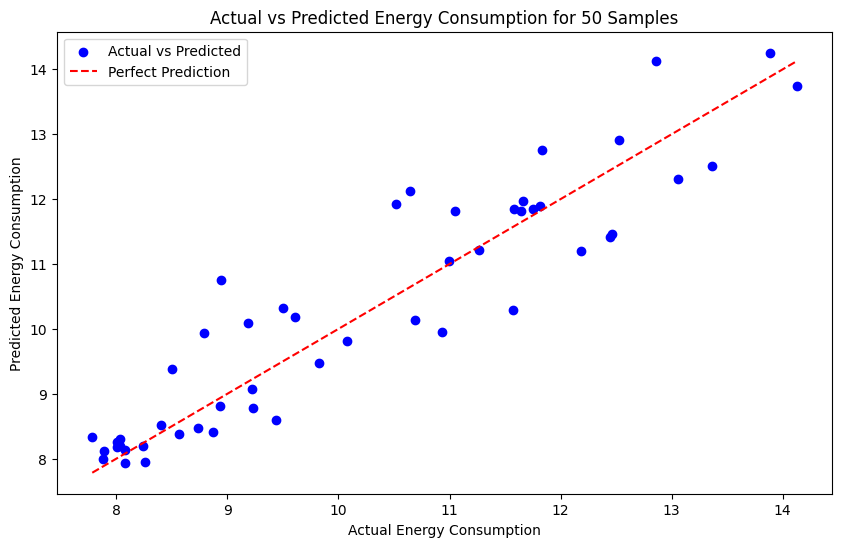

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Select 10 samples from test data
sample_indices = np.random.choice(X_test_gru.shape[0],50, replace=False)
X_test_sample = X_test_gru[sample_indices]
y_test_sample = y_test.iloc[sample_indices]  # Use .iloc for positional indexing
y_pred_sample = model.predict(X_test_sample)

# Plot actual vs predicted values for the 10 samples
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(y_test_sample)), y_test_sample, color='blue', marker='o', linestyle='dashed', label='Actual')
plt.plot(np.arange(len(y_pred_sample)), y_pred_sample, color='red', marker='x', linestyle='dashed', label='Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Energy Consumption')
plt.title('Actual vs Predicted Energy Consumption for 50 Samples')
plt.legend()
plt.show()

# Scatter plot of actual vs predicted values for the 10 samples
plt.figure(figsize=(10, 6))
plt.scatter(y_test_sample, y_pred_sample, color='blue', label='Actual vs Predicted')
plt.plot([y_test_sample.min(), y_test_sample.max()], [y_test_sample.min(), y_test_sample.max()], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Energy Consumption')
plt.ylabel('Predicted Energy Consumption')
plt.title('Actual vs Predicted Energy Consumption for 50 Samples')
plt.legend()
plt.show()


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 8, 128)         │        50,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 8, 64)          │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 290,981 (1.11 MB)

 Trainable params: 96,993 (378.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 193,988 (757.77 KB)